# Feature Importance

In this notebook, we try to identify and compare the features important to the relative model class. 

# Setup

In [1]:
# define the paths
import sys

basepath = "../"  # Project directory
sys.path.append(basepath)

# AL Scripts
AL_SCRIPTS_PATH = basepath + "al_lib/"

sys.path.append({AL_SCRIPTS_PATH})

from al_lib.active_learning_setting import FeatureImportancePaths

PATHS = FeatureImportancePaths()
(AL_PATH, FI_PATH, DATA_PATH, FIGURE_PATH, ENV_PATH, RESULTS_PATH, LOG_DIR) = PATHS
# sys.path.extend(PATHS)

sys.path

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 {'../al_lib/'},
 '../',
 '../06_Feature_Importance/results/',
 '../06_Feature_Importance/',
 '../06_Feature_Importance/results/figures/',
 '../04_Active_Learning/',
 '../data/',
 '../06_Feature_Importance/logs/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib']

## Include a logger

In [2]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
date = datetime.datetime.now().strftime("%Y-%m-%d")

# date = now.strftime("%Y-%m-%d")
log_file_name = f"{date}_FeatImp.log"
log_file_path = f"{LOG_DIR}{log_file_name}"

# Create logger
logging = create_logger(__name__, log_file_path=log_file_path)
# Usage of the logger as follows:
logging.info("Logging started")
logging.info(f"log stored at: {log_file_path}")

2024-07-08 19:26:12 - INFO - Logging started
2024-07-08 19:26:12 - INFO - log stored at: ../06_Feature_Importance/logs/2024-07-08_FeatImp.log


# Imports
## Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge as KRR
import pandas as pd

### Import Data

In [4]:
# Define the datafile

data_name = "dpsDeriv1200.csv"

datafile = DATA_PATH + data_name

from al_lib.helper_functions import import_dpsDeriv1200
import pandas as pd

data = import_dpsDeriv1200(datafile)
logging.info(f"Data loaded and preprocessed from {datafile}")

2024-07-08 19:26:14 - INFO - Data loaded and preprocessed from ../data/dpsDeriv1200.csv


## Split into feature and target variables

In [5]:
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

In [6]:
rscv_results_dir = basepath + "03_Modelling/03_1_rscv/rscv_results/"
gscv_results_dir = basepath + "03_Modelling/03_2_gscv/gscv_results/"

# models tested
models = ["hgb", "krr", "mlp", "pls", "rf", "xgb"]

from al_lib.helper_functions import _get_optimal_params_from_cv

optimal_params, rmse_from_cv, models_available = _get_optimal_params_from_cv(models, gscv_results_dir, rscv_results_dir, logging=logging)

2024-07-08 19:26:14 - INFO - Loaded the rscv results: hgb from ../03_Modelling/03_1_rscv/rscv_results/hgb_rscv_results.csv
2024-07-08 19:26:14 - INFO - Loaded the gscv results: krr from ../03_Modelling/03_2_gscv/gscv_results/krr_gscv_results.csv
2024-07-08 19:26:14 - INFO - Loaded the gscv results: mlp from ../03_Modelling/03_2_gscv/gscv_results/mlp_gscv_results.csv
2024-07-08 19:26:14 - INFO - Loaded the gscv results: pls from ../03_Modelling/03_2_gscv/gscv_results/pls_gscv_results.csv
2024-07-08 19:26:14 - INFO - Loaded the gscv results: rf from ../03_Modelling/03_2_gscv/gscv_results/rf_gscv_results.csv
2024-07-08 19:26:14 - INFO - Loaded the rscv results: xgb from ../03_Modelling/03_1_rscv/rscv_results/xgb_rscv_results.csv


In [7]:
for model in models_available:
    if models_available[model]:
        logging.info(f"Optimal parameters (GSCV) for {model} with RMSE {rmse_from_cv[model]}: {optimal_params[model]}")
    else:
        logging.info(f"Optimal parameters (RSCV) for {model} with RMSE {rmse_from_cv[model]}: {optimal_params[model]}")

2024-07-08 19:26:14 - INFO - Optimal parameters (GSCV) for hgb with RMSE 97.0: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-07-08 19:26:14 - INFO - Optimal parameters (GSCV) for krr with RMSE 101.0: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-07-08 19:26:14 - INFO - Optimal parameters (GSCV) for mlp with RMSE 138.0: {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
2024-07-08 19:26:14 - INFO - Optimal parameters (GSCV) for pls with RMSE 110.0: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-07-08 19:26:14 - INFO - Optimal parameters (GSCV) for rf with RMSE 117.0: {'max_depth': np.i

In [8]:
# generate object with the optimized parameters to hand over to the Regressors
for key in optimal_params.keys():
    # generate a global variable with the optimal parameters
    globals()[f"params_{key}"] = optimal_params[key]


for key in optimal_params.keys():
    logging.info(f"Optimal parameters for {key}: {optimal_params[key]}")

2024-07-08 19:26:14 - INFO - Optimal parameters for hgb: {'learning_rate': np.float64(0.04262389603635252), 'loss': 'squared_error', 'max_iter': 267, 'max_leaf_nodes': 16, 'min_samples_leaf': 8}
2024-07-08 19:26:14 - INFO - Optimal parameters for krr: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'rbf'}
2024-07-08 19:26:14 - INFO - Optimal parameters for mlp: {'activation': 'identity', 'alpha': np.float64(0.030087981364603892), 'early_stopping': np.True_, 'hidden_layer_sizes': np.int64(195), 'solver': 'lbfgs', 'validation_fraction': np.float64(0.1381305094147183)}
2024-07-08 19:26:14 - INFO - Optimal parameters for pls: {'copy': np.True_, 'max_iter': np.int64(201), 'n_components': np.int64(14), 'scale': np.False_, 'tol': np.float64(0.3000640615051812)}
2024-07-08 19:26:14 - INFO - Optimal parameters for rf: {'max_depth': np.int64(16), 'max_features': np.int64(7), 'min_samples_split': np.int64(6), 'n_estimators': np.int64(75)}
2024-07-08 

## Calculate the feature importance

Some methods have a built in method to estimate or determine the feature importance for each feature. We will retrieve the feature importance for the methods were this is available. For the other methods the feature importance will be calculated using the Permuation feature importance from sklearn. 


https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance



In [9]:
# calculate the feature importance using permutation importance

from sklearn.inspection import permutation_importance
random_state = 202375

In [10]:

# Import the Regressors

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.cross_decomposition import PLSRegression as PLS
from xgboost import XGBRegressor as XGB

from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict


In [11]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(fitted_regressor, X, y, ax):
    result = permutation_importance(fitted_regressor, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [20]:
def compare_feature_importance(X, y, models, params, random_state, logging, filepath):
    feature_importance_collection = pd.DataFrame(index=X.columns)
    for regressor, param in zip(models, params):
        feature_importance = pd.DataFrame()
        # define parameters
        figsize = (12,8)
        # fit the model
        model = regressor(**param)
        validation_size = 0.2
        test_size = 0.3
        (
            X_remainder,
            X_val,
            y_remainder,
            y_val,
        ) = train_test_split(X, y, test_size=validation_size, random_state=random_state)

        # split the remainder into training and test (30%) set
        X_train, X_test, y_train, y_test = train_test_split(
            X_remainder, y_remainder, test_size=test_size, random_state=random_state
        )
        model.fit(X_train, y_train)
        # calculate the feature importance
        perm_result_train = permutation_importance(
            model, X_train, y_train, n_repeats=10, random_state=random_state, n_jobs=30
        )
        perm_result_test = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=30
        )
        perm_result_val = permutation_importance(
            model, X_val, y_val, n_repeats=10, random_state=random_state, n_jobs=30
        )

        # store the results in a dataframe
        feature_importance[f"perm_results_{regressor.__name__}train"] = [
            perm_result_train
        ]
        feature_importance[f"perm_results_{regressor.__name__}test"] = [
            perm_result_test
        ]
        feature_importance[f"perm_results_{regressor.__name__}val"] = [perm_result_val]

        # save the results
        filepath_model = f"{filepath}{regressor.__name__}_perm_importance.csv"
        feature_importance.to_csv(filepath_model)
        logging.info(f"Feature importance for {regressor.__name__} saved at {filepath_model}")

        perm_sorted_train_idx = perm_result_train.importances_mean.argsort()
        perm_sorted_test_idx = perm_result_test.importances_mean.argsort()
        perm_sorted_val_idx = perm_result_val.importances_mean.argsort()
        
        # create a plot of the feature importance
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey=True)
        ax1.boxplot(
            perm_result_train.importances.T, vert=False, labels=X.columns[perm_sorted_train_idx]
        )
        y_tick_distance = 25
        ax1.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        ax1.set_title(f"Feature importance {regressor.__name__} train")
        ax2.boxplot(
            perm_result_test.importances.T, vert=False, labels=X.columns[perm_sorted_test_idx]
        )
        ax2.set_title(f"Feature importance {regressor.__name__} test")
        ax3.boxplot(
            perm_result_val.importances.T, vert=False, labels=X.columns[perm_sorted_val_idx]
        )
        ax3.set_title(f"Feature importance {regressor.__name__} val")
        plt.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_perm_importance.png")
        plt.close()
        logging.info(f"Feature importance for {regressor.__name__} saved at {FIGURE_PATH}{regressor.__name__}_perm_importance.png")


        # create a bar plot of the feature importance
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey=True)
        
        ax1.barh(X.columns[perm_sorted_train_idx], perm_result_train.importances_mean[perm_sorted_train_idx])
        ax1.set_title(f"Train Set")

        ax2.barh(X.columns[perm_sorted_test_idx], perm_result_test.importances_mean[perm_sorted_test_idx])
        ax2.set_title(f"Test Set")

        ax3.barh(X.columns[perm_sorted_val_idx], perm_result_val.importances_mean[perm_sorted_val_idx])
        ax3.set_title(f"Validation Set")

        y_tick_distance = 25
        ax1.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        plt.title(f"Feature importance {regressor.__name__}")
        plt.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_perm_importance_v2.png")
        plt.close()
        logging.info(f"Feature importance for {regressor.__name__} saved at {FIGURE_PATH}{regressor.__name__}_perm_importance_v2.png")


        # create a bar plot of the feature importance (same as above without sorting)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        y_tick_distance = 25
        
        ax1.barh(X.columns[perm_sorted_train_idx], perm_result_train.importances_mean[perm_sorted_train_idx])
        ax1.set_title(f"Train Set")

        ax2.barh(X.columns[perm_sorted_test_idx], perm_result_test.importances_mean[perm_sorted_test_idx])
        ax2.set_title(f"Test Set")

        ax3.barh(X.columns[perm_sorted_val_idx], perm_result_val.importances_mean[perm_sorted_val_idx])
        ax3.set_title(f"Validation Set")


        ax1.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        ax2.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        ax3.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        plt.title(f"Feature importance {regressor.__name__}")
        plt.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_perm_importance_v3.png")
        plt.close()
        logging.info(f"Feature importance for {regressor.__name__} saved at {FIGURE_PATH}{regressor.__name__}_perm_importance_v3.png")



        # calculate the differences in feature importance between the training and test set
        diff_train_test = perm_result_train.importances_mean - perm_result_test.importances_mean
        diff_train_val = perm_result_train.importances_mean - perm_result_val.importances_mean
        diff_test_val = perm_result_test.importances_mean - perm_result_val.importances_mean

        # store the results in a dataframe
        feature_importance[f"diff_train_test_{regressor.__name__}"] = [diff_train_test]
        feature_importance[f"diff_train_val_{regressor.__name__}"] = [diff_train_val]
        feature_importance[f"diff_test_val_{regressor.__name__}"] = [diff_test_val]

        # save the results
        filepath_model = f"{filepath}{regressor.__name__}_diff_importance.csv"
        feature_importance.to_csv(filepath_model)
        logging.info(f"Differences in feature importance for {regressor.__name__} saved at {filepath_model}")
        
        # create a plot of the difference in feature importance
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey=True)
        y_tick_distance = 25

        ax1.barh(X.columns, diff_train_test)
        ax1.set_title(f"train-test ({regressor.__name__})")
        ax1.set_xlabel("Difference in feature importance")
        ax1.set_ylabel("Feature")
        ax1.set_yticks(np.arange(0, len(X.columns), y_tick_distance))

        ax2.barh(X.columns, diff_train_val)
        ax2.set_title(f"train-val ({regressor.__name__})")
        ax2.set_xlabel("Difference in feature importance")
        ax2.set_yticks(np.arange(0, len(X.columns), y_tick_distance))

        ax3.barh(X.columns, diff_test_val)
        ax3.set_title(f"test-val ({regressor.__name__})")
        ax3.set_xlabel("Difference in feature importance")
        ax3.set_yticks(np.arange(0, len(X.columns), y_tick_distance))
        plt.tight_layout()
        plt.close()

        # 3. plot the top 25 features for each model
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.barh(X.columns[perm_sorted_train_idx][-25:], perm_result_train.importances_mean[perm_sorted_train_idx][-25:])
        ax.set_title(f"Top 25 features {regressor.__name__} train")
        plt.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_top25.png")
        plt.close()
        logging.info(f"Top 25 features for {regressor.__name__} saved at {FIGURE_PATH}{regressor.__name__}_top25.png")

        # create a entry in the feature_importance_collection
        feature_importance_collection[f"{regressor.__name__}_train"] = perm_result_train.importances_mean
        feature_importance_collection[f"{regressor.__name__}_test"] = perm_result_test.importances_mean
        feature_importance_collection[f"{regressor.__name__}_val"] = perm_result_val.importances_mean

        # perform Multicolinear Features Analysis
        # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        corr = spearmanr(X).correlation

        # Ensure the correlation matrix is symmetric
        corr = (corr + corr.T) / 2
        np.fill_diagonal(corr, 1)

        # correlation matrix todistance matrix using Ward's linkage.
        distance_matrix = 1 - np.abs(corr)
        dist_linkage = hierarchy.ward(squareform(distance_matrix))
        dendro = hierarchy.dendrogram(
            dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
        )
        dendro_idx = np.arange(0, len(dendro["ivl"]), 100)

        ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="hot")
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro_idx, rotation="horizontal")
        ax2.set_yticklabels(dendro_idx)


        ax2.get_xaxis().set_tick_params(which="both", direction="out")


        
        ax2.legend(["High", "Low"])
        ax2.set_title("Spearman correlation")
        # cbar = ax2.figure.colorbar(ax2.imshow(corr, cmap="hot"), ax=ax2)
        cbar = ax2.figure.colorbar(ax2.images[0], ax=ax2, location = "bottom", shrink=0.5)
        cbar.set_label("Spearmann correlation coefficient")
        plt.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_multicolinear_features_dendrogram.png")
        plt.show()

        # manually pick a threshold for multicolinear features
        crit = 10
        cluster_ids = hierarchy.fcluster(dist_linkage, crit, criterion="maxclust")
        cluster_id_to_feature_ids = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            cluster_id_to_feature_ids[cluster_id].append(idx)
        selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
        selected_features_names = X.columns[selected_features]

        X_train_sel = X_train[selected_features_names]
        X_test_sel = X_test[selected_features_names]

        # fit the model
        # change the n_components value in the paramslist if necessary
        if regressor == PLS:
            param["n_components"] = 5

        model_sel = regressor(**param)
        model_sel.fit(X_train_sel, y_train)
        # calculate the feature importance
        logging.info(f"Accuracy of the model with multicolinear features only: {model_sel.score(X_test_sel, y_test):.2f}")

        fig, ax = plt.subplots(figsize=(10,8))
        plot_permutation_importance(model_sel, X_test_sel, y_test, ax)
        ax.set_title(f"Permutation Importances on selected subset of features\n(test set with multicolinear features only and {regressor.__name__} model)")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()

        _ = fig.tight_layout()
        plt.savefig(f"{FIGURE_PATH}{regressor.__name__}_multicolinear_features.png")
        plt.close()
    
    # save the feature importance collection
    feature_importance_collection.to_csv(f"{filepath}feature_importance_collection.csv")

    # calculate the mean feature importance over all models using the test feature importance
    feature_importance_mean = feature_importance_collection.filter(like="test").mean(axis=1)
    feature_importance_std = feature_importance_collection.filter(like="test").std(axis=1)
    feature_importance_mean_sorted = feature_importance_mean.sort_values(ascending=False)
    feature_importance_std = feature_importance_std.loc[feature_importance_mean.index]

    # save the index of the sorted feature importance top 25
    feature_importance_mean_sorted[:25].to_csv(f"{filepath}top25_features.csv")

    feat_imp_sort_idx = feature_importance_mean.argsort()

    # 3. plot the mean top 25 features
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # ax.barh(X.columns[feat_imp_sort_idx][-25:], feature_importance_mean[feat_imp_sort_idx][-25:])
    ax.set_title(f"Top 25 features mean")
    #add error bars
    ax.errorbar(feature_importance_mean[feat_imp_sort_idx][-25:], X.columns[feat_imp_sort_idx][-25:], xerr=feature_importance_std[feat_imp_sort_idx][-25:], fmt='o')
    plt.tight_layout()
    plt.savefig(f"{FIGURE_PATH}mean_top25_feature_importance.png")
    plt.show()
    plt.close()

2024-07-08 19:43:41 - INFO - Feature importance for HistGradientBoostingRegressor saved at ../06_Feature_Importance/results/HistGradientBoostingRegressor_perm_importance.csv
2024-07-08 19:44:00 - INFO - Feature importance for HistGradientBoostingRegressor saved at ../06_Feature_Importance/results/figures/HistGradientBoostingRegressor_perm_importance.png
2024-07-08 19:44:03 - INFO - Feature importance for HistGradientBoostingRegressor saved at ../06_Feature_Importance/results/figures/HistGradientBoostingRegressor_perm_importance_v2.png
2024-07-08 19:44:05 - INFO - Feature importance for HistGradientBoostingRegressor saved at ../06_Feature_Importance/results/figures/HistGradientBoostingRegressor_perm_importance_v3.png
2024-07-08 19:44:05 - INFO - Differences in feature importance for HistGradientBoostingRegressor saved at ../06_Feature_Importance/results/HistGradientBoostingRegressor_diff_importance.csv
2024-07-08 19:44:08 - INFO - Top 25 features for HistGradientBoostingRegressor saved 

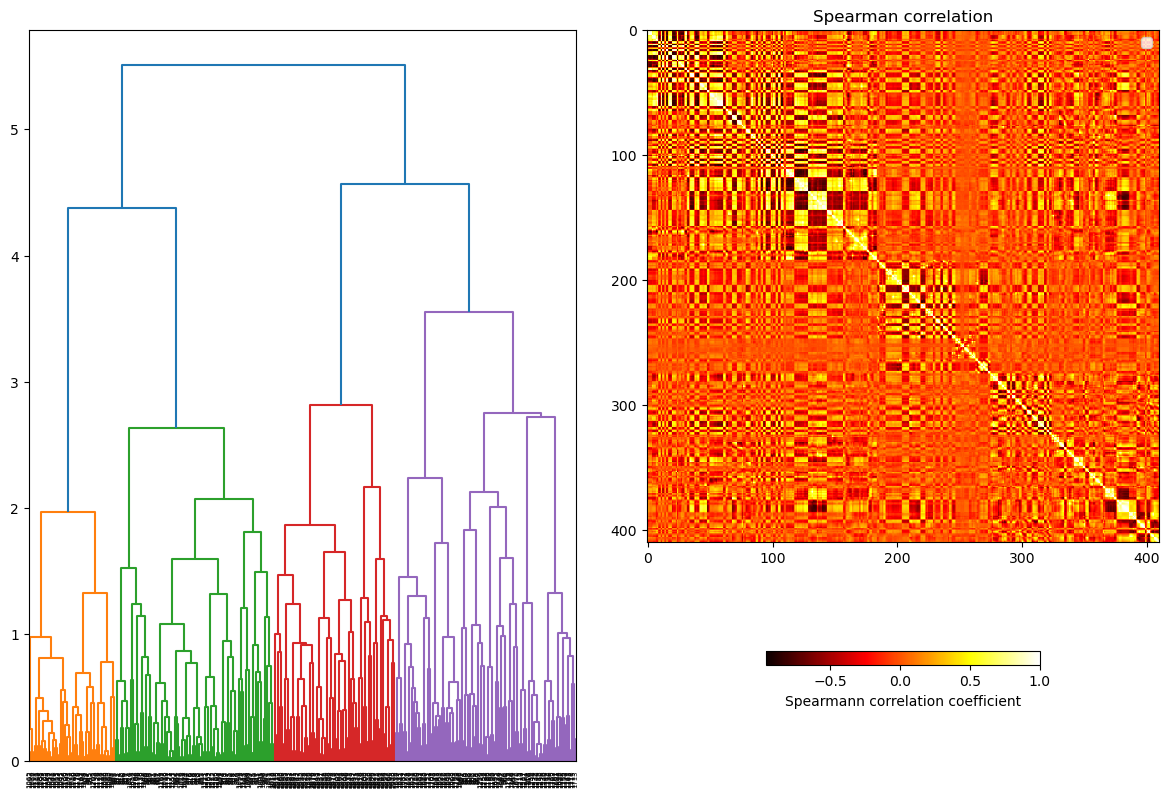

2024-07-08 19:44:18 - INFO - Accuracy of the model with multicolinear features only: 0.60
2024-07-08 19:44:34 - INFO - Feature importance for KernelRidge saved at ../06_Feature_Importance/results/KernelRidge_perm_importance.csv
2024-07-08 19:44:54 - INFO - Feature importance for KernelRidge saved at ../06_Feature_Importance/results/figures/KernelRidge_perm_importance.png
2024-07-08 19:44:57 - INFO - Feature importance for KernelRidge saved at ../06_Feature_Importance/results/figures/KernelRidge_perm_importance_v2.png
2024-07-08 19:44:59 - INFO - Feature importance for KernelRidge saved at ../06_Feature_Importance/results/figures/KernelRidge_perm_importance_v3.png
2024-07-08 19:44:59 - INFO - Differences in feature importance for KernelRidge saved at ../06_Feature_Importance/results/KernelRidge_diff_importance.csv
2024-07-08 19:45:01 - INFO - Top 25 features for KernelRidge saved at ../06_Feature_Importance/results/figures/KernelRidge_top25.png


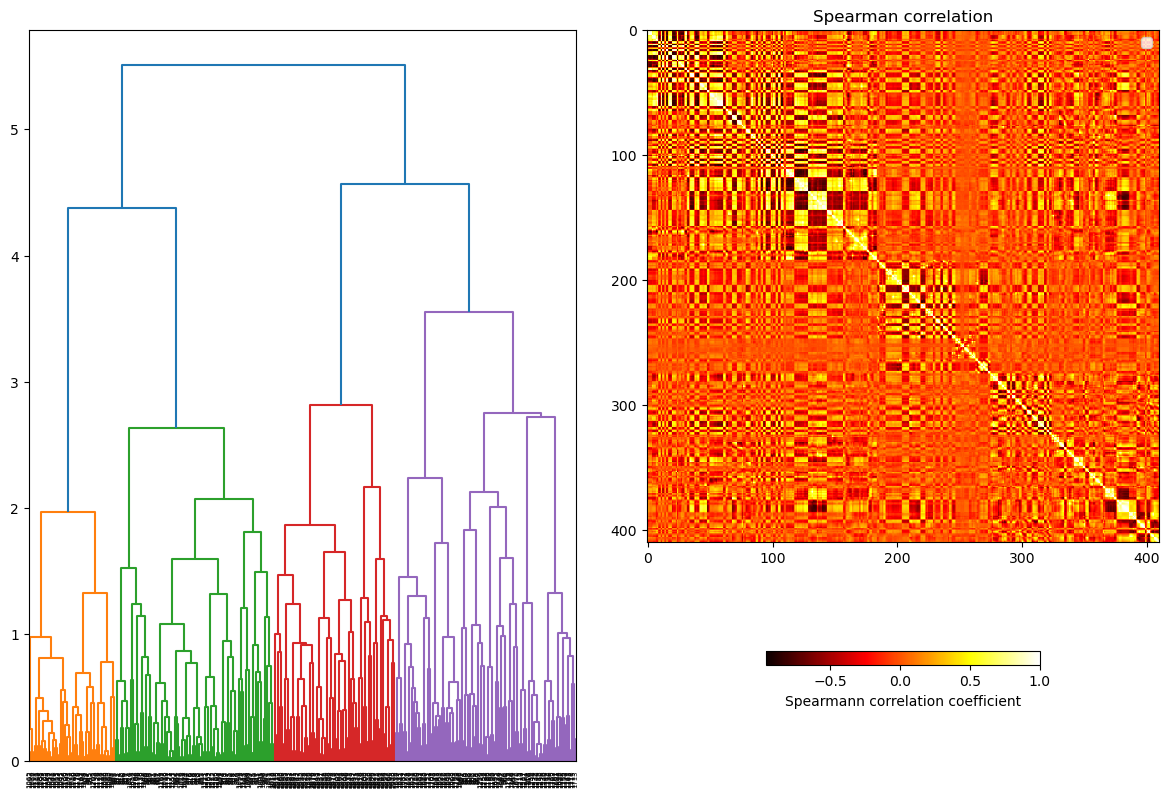

2024-07-08 19:45:11 - INFO - Accuracy of the model with multicolinear features only: 0.56
2024-07-08 19:45:21 - INFO - Feature importance for PLSRegression saved at ../06_Feature_Importance/results/PLSRegression_perm_importance.csv
2024-07-08 19:45:39 - INFO - Feature importance for PLSRegression saved at ../06_Feature_Importance/results/figures/PLSRegression_perm_importance.png
2024-07-08 19:45:42 - INFO - Feature importance for PLSRegression saved at ../06_Feature_Importance/results/figures/PLSRegression_perm_importance_v2.png
2024-07-08 19:45:45 - INFO - Feature importance for PLSRegression saved at ../06_Feature_Importance/results/figures/PLSRegression_perm_importance_v3.png
2024-07-08 19:45:45 - INFO - Differences in feature importance for PLSRegression saved at ../06_Feature_Importance/results/PLSRegression_diff_importance.csv
2024-07-08 19:45:47 - INFO - Top 25 features for PLSRegression saved at ../06_Feature_Importance/results/figures/PLSRegression_top25.png


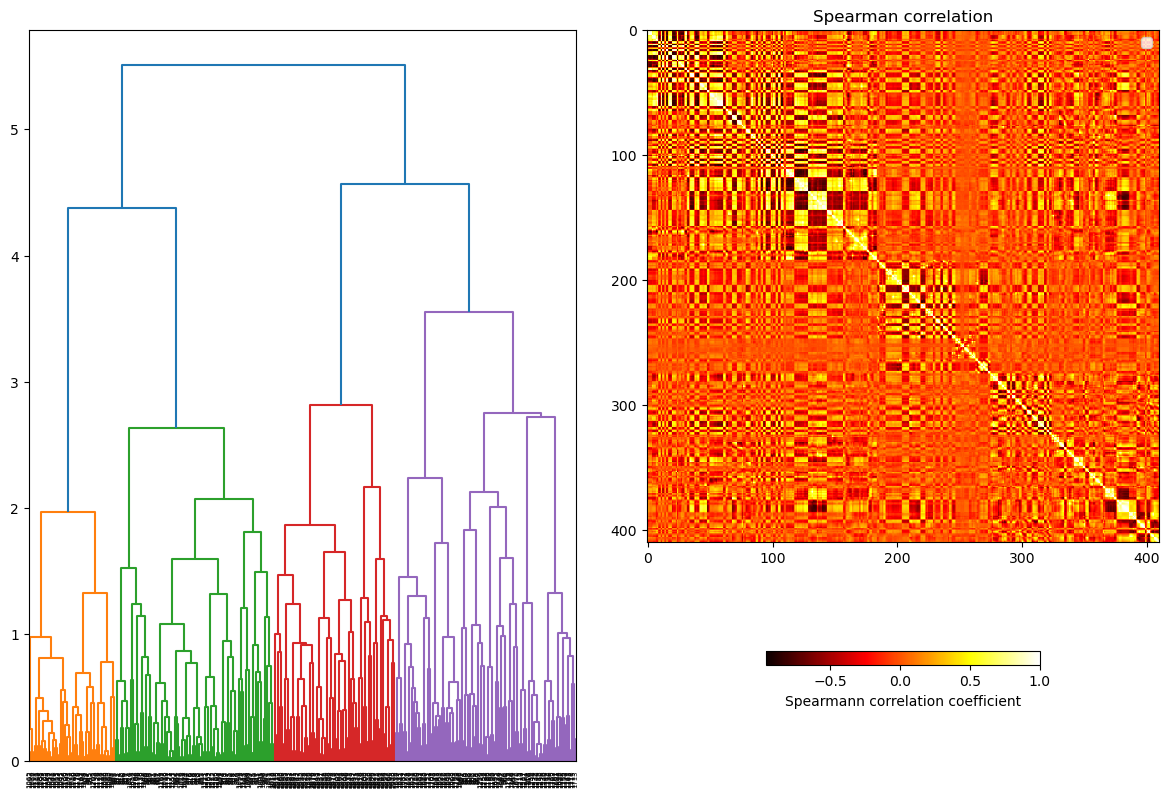

2024-07-08 19:45:56 - INFO - Accuracy of the model with multicolinear features only: 0.55
2024-07-08 19:46:25 - INFO - Feature importance for RandomForestRegressor saved at ../06_Feature_Importance/results/RandomForestRegressor_perm_importance.csv
2024-07-08 19:46:44 - INFO - Feature importance for RandomForestRegressor saved at ../06_Feature_Importance/results/figures/RandomForestRegressor_perm_importance.png
2024-07-08 19:46:47 - INFO - Feature importance for RandomForestRegressor saved at ../06_Feature_Importance/results/figures/RandomForestRegressor_perm_importance_v2.png
2024-07-08 19:46:49 - INFO - Feature importance for RandomForestRegressor saved at ../06_Feature_Importance/results/figures/RandomForestRegressor_perm_importance_v3.png
2024-07-08 19:46:50 - INFO - Differences in feature importance for RandomForestRegressor saved at ../06_Feature_Importance/results/RandomForestRegressor_diff_importance.csv
2024-07-08 19:46:51 - INFO - Top 25 features for RandomForestRegressor save

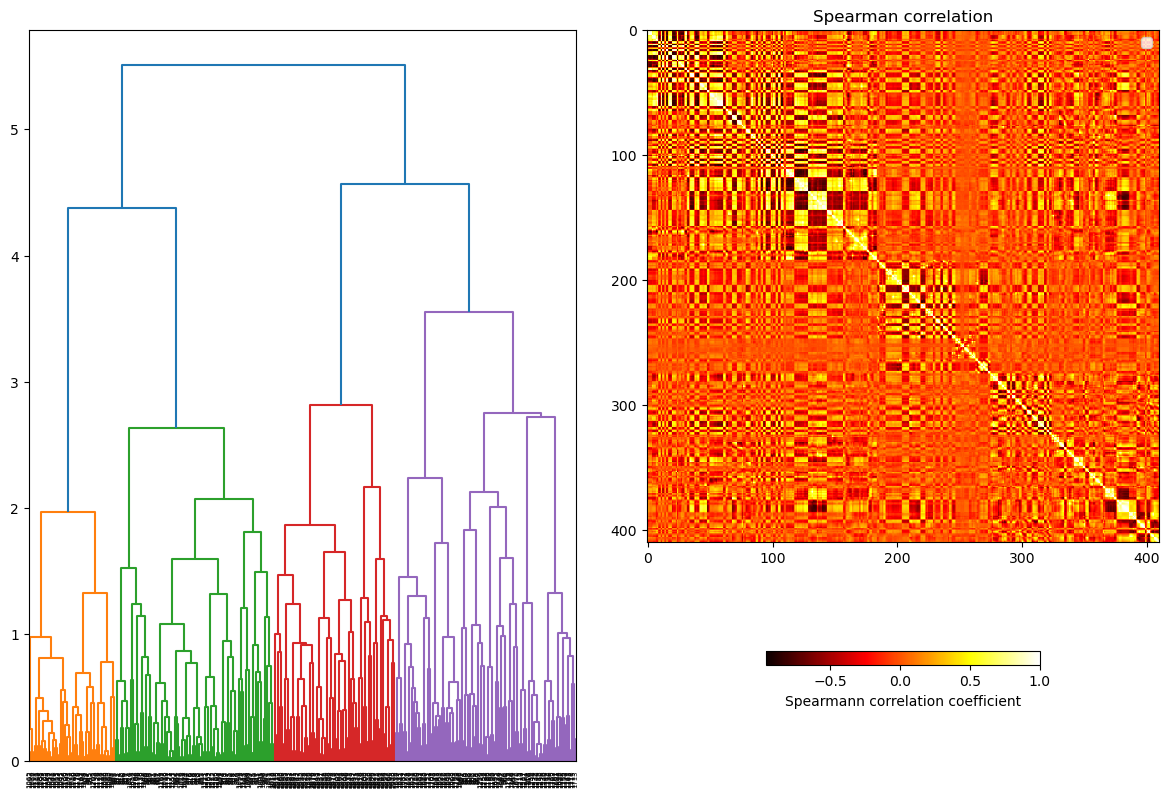

2024-07-08 19:47:01 - INFO - Accuracy of the model with multicolinear features only: 0.61
2024-07-08 19:47:39 - INFO - Feature importance for XGBRegressor saved at ../06_Feature_Importance/results/XGBRegressor_perm_importance.csv
2024-07-08 19:47:58 - INFO - Feature importance for XGBRegressor saved at ../06_Feature_Importance/results/figures/XGBRegressor_perm_importance.png
2024-07-08 19:48:01 - INFO - Feature importance for XGBRegressor saved at ../06_Feature_Importance/results/figures/XGBRegressor_perm_importance_v2.png
2024-07-08 19:48:04 - INFO - Feature importance for XGBRegressor saved at ../06_Feature_Importance/results/figures/XGBRegressor_perm_importance_v3.png
2024-07-08 19:48:04 - INFO - Differences in feature importance for XGBRegressor saved at ../06_Feature_Importance/results/XGBRegressor_diff_importance.csv
2024-07-08 19:48:06 - INFO - Top 25 features for XGBRegressor saved at ../06_Feature_Importance/results/figures/XGBRegressor_top25.png


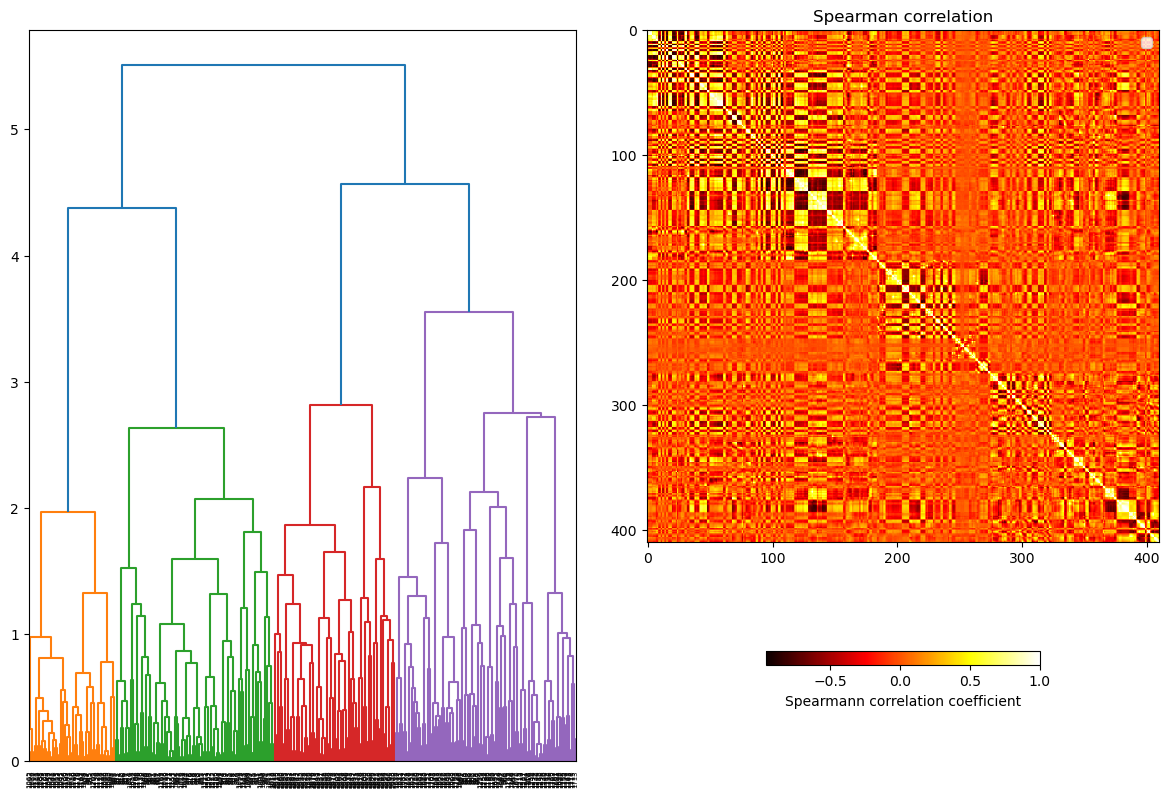

2024-07-08 19:48:16 - INFO - Accuracy of the model with multicolinear features only: 0.60
/tmp/ipykernel_3050193/2225321119.py:259: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(feature_importance_mean[feat_imp_sort_idx][-25:], X.columns[feat_imp_sort_idx][-25:], xerr=feature_importance_std[feat_imp_sort_idx][-25:], fmt='o')


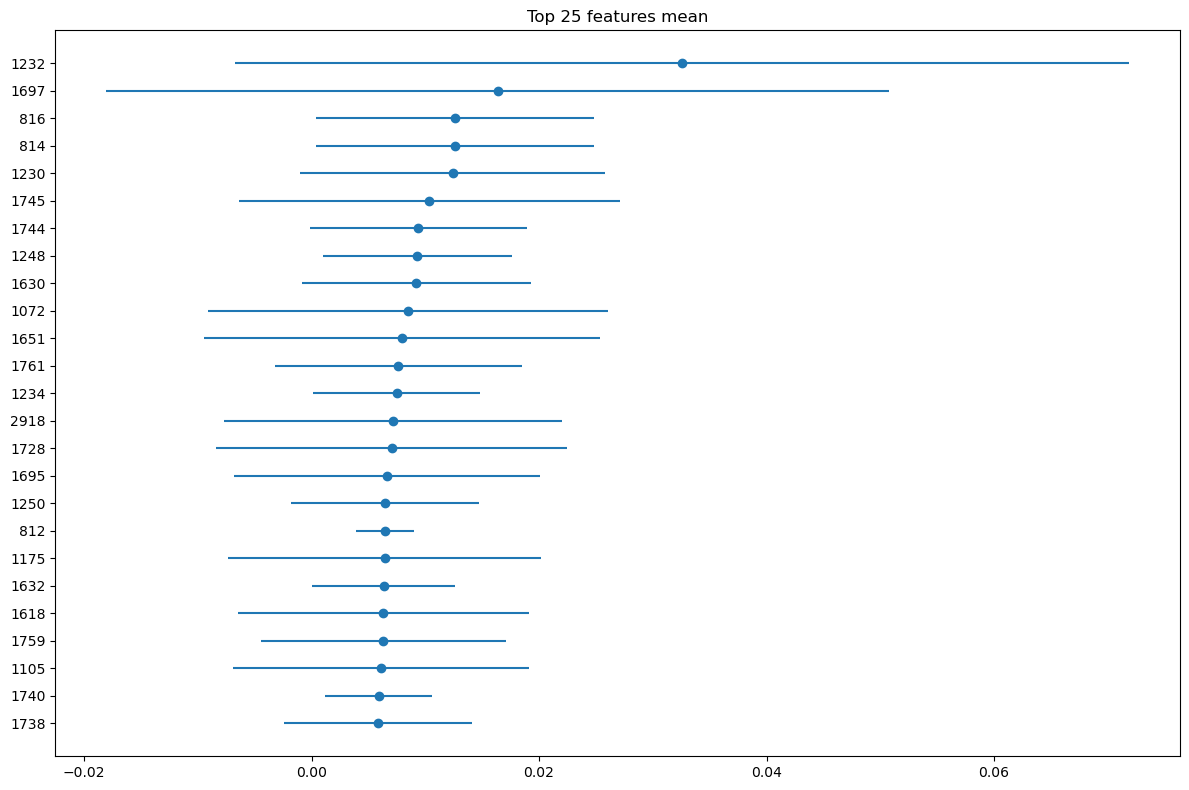

In [22]:
models_list = ["hgb", "krr", "pls", "rf", "xgb"]
regressor_list = [HGB, KRR, PLS, RF, XGB]
params = [params_hgb, params_krr, params_pls, params_rf, params_xgb]

# models_list = ["krr", "pls"]
# regressor_list = [KRR,PLS]
# params = [params_krr, params_pls]

# run the feature importance comparison
filepath = RESULTS_PATH
compare_feature_importance(X, y, regressor_list, params, random_state, logging, filepath=filepath)
